In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [71]:
train_path='/content/drive/MyDrive/498ds/Training'

In [72]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [81]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images = []
        self.transform = transform
        no_tumor_folder = os.path.join(root_dir, 'no_tumor')
        img_files = glob.glob(os.path.join(no_tumor_folder, '*.jpg'))
        self.images.extend(img_files)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

dataset = BrainTumorDataset(train_path, transform)
dataloader = DataLoader(dataset, batch_size=64,num_workers=2,pin_memory=True, shuffle=True)


In [82]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),   # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),     # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [83]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 2, 1, bias=False),  # Output shape (batch,1,4,4)

        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1).mean(1)  # Average over spatial dims

# WGAN loss
def generator_loss(fake_scores):
    return -fake_scores.mean()

def discriminator_loss(real_scores, fake_scores):
    return fake_scores.mean() - real_scores.mean()



In [84]:
def compute_gradient_penalty(D, real_samples, fake_samples, device="cuda"):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [85]:
nz = 100  # size of latent vector
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

In [86]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.9))


In [95]:
num_epochs = 500
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise).detach()

        real_scores = netD(real_images)
        fake_scores = netD(fake_images)
        gp = compute_gradient_penalty(netD, real_images, fake_images, device=device)

        d_loss = discriminator_loss(real_scores, fake_scores) + 10 * gp

        optimizerD.zero_grad()
        d_loss.backward()
        optimizerD.step()

        # Train Generator twice
        if i % 3 == 0:
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            fake_scores = netD(fake_images)

            g_loss = generator_loss(fake_scores)

            optimizerG.zero_grad()
            g_loss.backward()
            optimizerG.step()

    print(f"Epoch {epoch}: D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

Epoch 0: D_loss: -15.2211, G_loss: 25.9864
Epoch 1: D_loss: 1.2597, G_loss: 38.4355
Epoch 2: D_loss: -13.6051, G_loss: 29.2089
Epoch 3: D_loss: -9.4093, G_loss: 44.1225
Epoch 4: D_loss: -13.7140, G_loss: 39.9498
Epoch 5: D_loss: 214.4117, G_loss: 35.5772
Epoch 6: D_loss: -9.8469, G_loss: 30.0861
Epoch 7: D_loss: -12.1620, G_loss: 27.3049
Epoch 8: D_loss: -11.2090, G_loss: 32.0380
Epoch 9: D_loss: -17.3193, G_loss: 32.1667
Epoch 10: D_loss: -12.7118, G_loss: 42.1350
Epoch 11: D_loss: -17.8712, G_loss: 36.2073
Epoch 12: D_loss: -13.1198, G_loss: 36.4991
Epoch 13: D_loss: -8.4213, G_loss: 36.3354
Epoch 14: D_loss: -10.6878, G_loss: 36.6783
Epoch 15: D_loss: -12.4347, G_loss: 41.0377
Epoch 16: D_loss: -17.3522, G_loss: 30.7185
Epoch 17: D_loss: -13.4552, G_loss: 33.3751
Epoch 18: D_loss: -12.1171, G_loss: 28.8944
Epoch 19: D_loss: -24.0138, G_loss: 21.5437
Epoch 20: D_loss: -10.3827, G_loss: 31.9235
Epoch 21: D_loss: -22.7558, G_loss: 34.6721
Epoch 22: D_loss: -9.7316, G_loss: 35.3104
Epoc

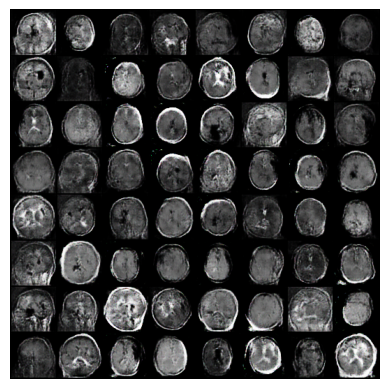

In [96]:
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_grid = make_grid(fake, padding=2, normalize=True)
    plt.imshow(np.transpose(img_grid, (1,2,0)))
    plt.axis('off')
    plt.show()

In [97]:
import torchvision.utils as vutils

output_dir = '/content/drive/MyDrive/Generated'
os.makedirs(output_dir, exist_ok=True)

# Generate 10 images
num_images = 10
noise = torch.randn(num_images, nz, 1, 1, device=device)
fake_images = netG(noise)

# Save the images
for i in range(num_images):
    # Save each image as a separate PNG file
    image_path = os.path.join(output_dir, f"generated_{i+1}.png")
    vutils.save_image(fake_images[i].detach(), image_path, normalize=True)
    print(f"Saved image {i+1} to {image_path}")

Saved image 1 to /content/drive/MyDrive/Generated/generated_1.png
Saved image 2 to /content/drive/MyDrive/Generated/generated_2.png
Saved image 3 to /content/drive/MyDrive/Generated/generated_3.png
Saved image 4 to /content/drive/MyDrive/Generated/generated_4.png
Saved image 5 to /content/drive/MyDrive/Generated/generated_5.png
Saved image 6 to /content/drive/MyDrive/Generated/generated_6.png
Saved image 7 to /content/drive/MyDrive/Generated/generated_7.png
Saved image 8 to /content/drive/MyDrive/Generated/generated_8.png
Saved image 9 to /content/drive/MyDrive/Generated/generated_9.png
Saved image 10 to /content/drive/MyDrive/Generated/generated_10.png


In [98]:
torch.save(netG.state_dict(), '/content/drive/MyDrive/Generated/generator_model.pth')
torch.save(netD.state_dict(), '/content/drive/MyDrive/Generated/discriminator_model.pth')

print("Models saved!")


Models saved!
